# Credit Risk Analysis
Credit scores are essential for credit granting and financial institutions to decide whether or not give credit to someone.In this analysis, we  experiment on  features and develop a scorecard , which can be used not only to identify High risk customers and but also to minimize further risks.

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Importing libraries

In [0]:
import csv
import pandas as pd #data preprocessing
import numpy as np #linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display  import display
pd.options.display.max_columns=None
%matplotlib inline
from sklearn import preprocessing 
from sklearn.decomposition import PCA # used for dimension reduction
import math  # for log function
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

sns.set( palette='deep')

## 1. DATA IMPORT

#### Loading Input Files
Loading 3 input files dropping the indexes, 

In [0]:
Borrower=pd.read_csv('Borrower Information.csv').drop('Unnamed: 0', axis = 1)
print('The Borrower File contains ',Borrower.shape[0],' rows and ',Borrower.shape[1],' columns')

The Borrower File contains  887379  rows and  13  columns


In [0]:
Loan_classification=pd.read_csv("Loan Classification Information.csv").drop('Unnamed: 0', axis = 1)
print('The Loan_classification File contains ',Loan_classification.shape[0],' rows and ',Loan_classification.shape[1],' columns')

The Loan_classification File contains  887379  rows and  17  columns


In [0]:
Loan_payment=pd.read_csv('Loan Payment Information.csv').drop('Unnamed: 0', axis = 1)
print('The Loan_payment File contains ',Loan_payment.shape[0],' rows and ',Loan_payment.shape[1],' columns')

The Loan_payment File contains  887379  rows and  40  columns


####  Duplicate check 



Duplicate check implemented on all input files, No Duplicates found .

In [0]:
# Borrower[Borrower['member_id'].duplicated() == True]
print(Borrower.duplicated().sum(), 'duplicates found in Borrower')

0 duplicates found in Borrower


In [0]:
# Loan_classification[Loan_classification['id'].duplicated() == True].count()
print(Loan_classification.duplicated().sum(), 'duplicates found in Loan_classification')

0 duplicates found in Loan_classification


In [0]:
# Loan_payment[Loan_payment['id'].duplicated() == True].count()
print(Loan_payment.duplicated().sum(), 'duplicates found in Loan_payment')

0 duplicates found in Loan_payment


####  Merge 
Let's merge these three files.

Borrower contains information about Customer with 'Member_id'

Load_classification contains information about loans with 'id' wrt customer' Member_id'

Loan_payment contains information about payment wrt loan 'id'

In [0]:
Borrower_Loan= pd.merge(Borrower, Loan_classification, on='member_id')

In [0]:
Borrower_Loan_payment= pd.merge(Borrower_Loan, Loan_payment, on='id')

The merged file is ready with 887379 records with 68 columns .Column datatypes are integer, float and object.

## 2. DATA ANALYSIS

####  Missing Values

We have seen that out dataset contains many null values and it is difficult to maintain big dataframe for better visualization and developement.Probably there are many columns that have more than 50% null values.

Below, We can find the columns that have more than 80% null values in them.
If there are any columns like those, then that means that the contribution of those columns in the Value of the model will be extremely low.And it will be better to drop them.Let's take a look.


In [0]:
pct_null = Borrower_Loan_payment.isnull().sum() / len(Borrower_Loan_payment)
Features_withNull = pct_null[pct_null > 0.84].index

In [0]:
print(len(Features_withNull), 'columns having more than 84% NULL values in them \n')
Features_withNull


18 columns having more than 84% NULL values in them 



Index(['annual_inc_joint', 'desc', 'mths_since_last_record', 'dti_joint',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m'],
      dtype='object')

In [0]:
print('Dropping the above mentioned Irrelevant columns')
Borrower_Loan_payment.drop(Features_withNull,axis=1,inplace=True)

Dropping the above mentioned Irrelevant columns


##### Dropping Irrelevant columns

In [0]:
Borrower_Loan_payment.drop(['member_id','id'],axis=1, inplace=True)

#### Data Transformation
We have make little data imputations in our columns .
1. 'Emp_title' contains profession of the customer and it has missing text.We can fill it with '_' 
2. 'title' contains the description provided by borrower for the loan and it resembles 'purpose' column too .hence it can be dropped

3. 'term' means the duration for the loan and it has data in format '30 months' . we can strip ' months ' text from it. 
4. 'emp_length' contains the number of employement years of customer.it contains '10+ years', '<1 year' sort of values.We can strip 'years' text and make data look more meaningfull.

In [0]:
Borrower_Loan_payment['emp_title'].fillna('Missing',inplace=True)
Borrower_Loan_payment.drop(['title'], axis=1,inplace=True)
Borrower_Loan_payment['term']=Borrower_Loan_payment['term'].str.strip('months')
Borrower_Loan_payment['emp_length'] = Borrower_Loan_payment.emp_length.apply(lambda x : '0' if x == '< 1 year' else '10' if x == '10+ years' else x ) 
Borrower_Loan_payment['emp_length'] = Borrower_Loan_payment['emp_length'].str.replace('year','')
Borrower_Loan_payment['emp_length'] = Borrower_Loan_payment['emp_length'].str.replace('s','')
Borrower_Loan_payment.emp_length.fillna('-1',inplace=True)

#### Date columns 
Data Columns can be split into year and months for better meaning of the data.

We have 5 date columns - earliest_cr_line,  issue_d,  last_pymnt_d,  last_credit_pull_d,  next_pymnt_d

Filling  NaN values with '-' in these columns to avoid code failure.

In [0]:
Borrower_Loan_payment.last_pymnt_d.fillna('-',inplace=True)
Borrower_Loan_payment.last_credit_pull_d.fillna('_',inplace=True)
Borrower_Loan_payment.next_pymnt_d.fillna('_',inplace=True)
Borrower_Loan_payment.earliest_cr_line.fillna('_',inplace=True)

In [0]:
earliest_cr_line_df = pd.DataFrame(Borrower_Loan_payment.earliest_cr_line.str.split('-',1).tolist(),
                          columns = ['earliest_cr_line_month','earliest_cr_line_year'])
issue_date_df = pd.DataFrame(Borrower_Loan_payment.issue_d.str.split('-',1).tolist(),
                          columns = ['issue_month','issue_year'])
last_pymnt_df = pd.DataFrame(Borrower_Loan_payment.last_pymnt_d.str.split('-',1).tolist(),
                          columns = ['last_pymnt_month','last_pymnt_year'])
last_credit_pull_df = pd.DataFrame(Borrower_Loan_payment.last_credit_pull_d.str.split('-',1).tolist(),
                          columns = ['last_credit_pull_month','last_credit_pull_year'])
next_pymnt_df = pd.DataFrame(Borrower_Loan_payment.next_pymnt_d.str.split('-',1).tolist(),
                          columns = ['next_pymnt_month','next_pymnt_year'])

In [0]:
Borrower_Loan_payment=pd.concat([Borrower_Loan_payment,earliest_cr_line_df,issue_date_df,last_pymnt_df,last_credit_pull_df,next_pymnt_df], axis=1).reset_index()

####  Rest columns  with NaN values
Few columns are still left with NaN values.

Let's fill the with 0 for the moment.

In [0]:
Borrower_Loan_payment['tot_cur_bal']=Borrower_Loan_payment['tot_cur_bal'].fillna(0)
Borrower_Loan_payment['tot_coll_amt']=Borrower_Loan_payment['tot_coll_amt'].fillna(0)
Borrower_Loan_payment['mths_since_last_major_derog']=Borrower_Loan_payment['mths_since_last_major_derog'].fillna(0)
Borrower_Loan_payment['collections_12_mths_ex_med']=Borrower_Loan_payment['collections_12_mths_ex_med'].fillna(0)

Borrower_Loan_payment['revol_util']=Borrower_Loan_payment['revol_util'].fillna(0)
Borrower_Loan_payment['mths_since_last_delinq']=Borrower_Loan_payment['mths_since_last_delinq'].fillna(0)
Borrower_Loan_payment['annual_inc']=Borrower_Loan_payment['annual_inc'].fillna(0)

In [0]:
Borrower_Loan_payment[['emp_length','index','term','loan_amnt','funded_amnt']] = Borrower_Loan_payment[['index', 'emp_length','term','loan_amnt','funded_amnt']].astype(int)


Borrower_Loan_payment[['emp_title', 'home_ownership','zip_code','addr_state','grade','sub_grade','loan_status','pymnt_plan',
                                'purpose','application_type']] = Borrower_Loan_payment[['emp_title', 'home_ownership','zip_code','addr_state','grade','sub_grade','loan_status','pymnt_plan',
                                'purpose','application_type']].astype(object)
Borrower_Loan_payment[['annual_inc', 'open_acc','pub_rec','total_acc','delinq_2yrs','int_rate','funded_amnt_inv'
                          ,'installment','dti','inq_last_6mths','mths_since_last_delinq','revol_bal','revol_util',
                          'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
                          'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','collections_12_mths_ex_med',
                          'mths_since_last_major_derog','acc_now_delinq','tot_coll_amt','tot_cur_bal'
                          ]] = Borrower_Loan_payment[['annual_inc', 'open_acc','pub_rec','total_acc','delinq_2yrs','int_rate','funded_amnt_inv'
                          ,'installment','dti','inq_last_6mths','mths_since_last_delinq','revol_bal','revol_util',
                          'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
                          'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','collections_12_mths_ex_med',
                          'mths_since_last_major_derog','acc_now_delinq','tot_coll_amt','tot_cur_bal'
                          ]].astype(float)
Borrower_Loan_payment.drop(['earliest_cr_line','issue_d','last_pymnt_d','next_pymnt_d','last_credit_pull_d'], axis=1,inplace=True)

#### New Feature

Here, the relevant column is 'loan_status'.

'loan_status' = 'present status of the loan



In [0]:
Borrower_Loan_payment.loan_status.value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

A new feature 'Risk' is created based on 'loan_status' .

    when loan_status is  Current, fully paid, Does not meet the credit policy. Status:Fully Paid
        The Risk = 0 #### meaning the risk is low
    when loan_status is Charged off, In Grace Period,Late (16-30 days), Does not meet the credit policy. Status:Charged Off 
    ,Late (31-120 days) ,    
         The Risk = 1 #### meaning the risk is high

Before this, we can check for null values in  loan_status.

In [0]:
Borrower_Loan_payment.Risk=np.nan

In [0]:
highrisk = ["Charged Off","Late (31-120 days)", "In Grace Period", "Late (16-30 days)","Default", "Does not meet the credit policy. Status:Charged Off"]
def check_risk(row):
    if row in highrisk:
        return 'HighRisk'
    else:
        return 'LowRisk'
Borrower_Loan_payment['Risk']=Borrower_Loan_payment['loan_status'].apply(check_risk)  

In [0]:
# Borrower_Loan_payment.loc[Borrower_Loan_payment['delinq_2yrs'] > 0.0,'Risk'] = 1
# Borrower_Loan_payment.loc[Borrower_Loan_payment['delinq_2yrs'] == 0.0,'Risk'] = 0

In [0]:
Borrower_Loan_payment['Risk'].value_counts()

LowRisk     819950
HighRisk     67429
Name: Risk, dtype: int64

Checking the skewness of our dataset for Risk column

In [0]:
print('Low Risk-',round(Borrower_Loan_payment['Risk'].value_counts()["LowRisk"]/len(Borrower_Loan_payment) * 100,2),'% of the data\n')
print('High Risk-',round(Borrower_Loan_payment['Risk'].value_counts()["HighRisk"]/len(Borrower_Loan_payment) * 100,2),'% of the data')

Low Risk- 92.4 % of the data

High Risk- 7.6 % of the data


Text(0.5,1,'Risk Distribution \n  0: Low Risk          1: High Risk')

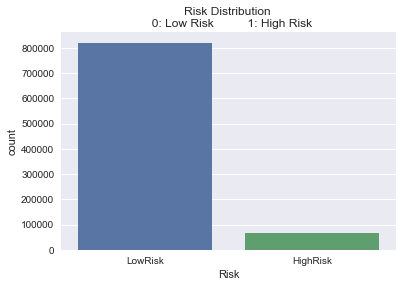

In [0]:
sns.countplot('Risk', data=Borrower_Loan_payment)
plt.title('Risk Distribution \n  0: Low Risk          1: High Risk')

In [0]:
Borrower_Loan_payment['annual_inc_bin'] = pd.cut(x=Borrower_Loan_payment['annual_inc'], bins=[0,100000, 200000, 300000, 400000,500000, 600000, 700000, 800000],labels=['L1','L2','L3','L4','L5','L6','L7','L8'])

In [0]:
HighRisk_data=Borrower_Loan_payment[Borrower_Loan_payment['Risk'] == 'HighRisk']

In [0]:
Data=Borrower_Loan_payment.copy()

# Visualization

Visualization is the best way of exploring the data.Let's gets started.First thing First.

OUTLIERS

1. A box plot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points.

The outliers are those that are not included in the box of observation i.e no where near the quartiles.

###### Loan status

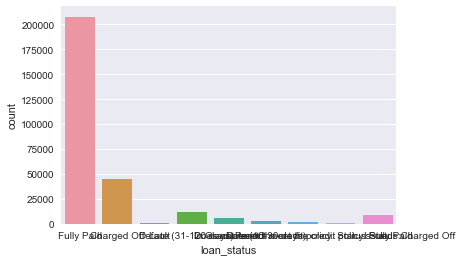

In [0]:
sns.countplot(x=Borrower_Loan_payment.loc[Borrower_Loan_payment['loan_status'] != 'Current'].loan_status)

##### Revolving utilization Rate

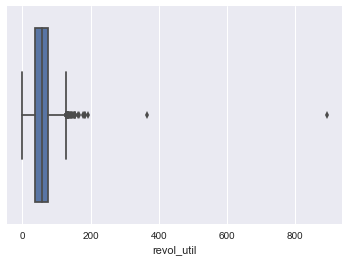

In [0]:
sns.boxplot(Borrower_Loan_payment['revol_util'])

we can see Outliers in Revolving utilization rate, although few values .

In [0]:
display(Borrower_Loan_payment.shape)
Borrower_Loan_payment[Borrower_Loan_payment['revol_util']> 200]#.shape
    

(887379, 55)

,index,emp_title,emp_length,home_ownership,zip_code,addr_state,annual_inc,open_acc,pub_rec,total_acc,delinq_2yrs,term,grade,sub_grade,loan_status,pymnt_plan,purpose,application_type,loan_amnt,int_rate,funded_amnt,funded_amnt_inv,installment,dti,inq_last_6mths,mths_since_last_delinq,revol_bal,revol_util,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,earliest_cr_line_month,earliest_cr_line_year,issue_month,issue_year,last_pymnt_month,last_pymnt_year,last_credit_pull_month,last_credit_pull_year,next_pymnt_month,next_pymnt_year,Risk,annual_inc_bin
368206,0,sales rep,368206,MORTGAGE,284xx,NC,48000.0,4.0,0.0,15.0,0.0,60,C,C4,In Grace Period,n,debt_consolidation,INDIVIDUAL,16500,14.49,16500,16500.0,388.14,9.33,0.0,0.0,2566.0,366.6,12727.23,12727.23,6986.52,6986.52,3772.77,3213.75,0.0,0.0,0.0,388.14,0.0,0.0,0.0,0.0,17390.0,Jun,1996,Jun,2014,Dec,2015,Dec,2015,Feb,2016,HighRisk,L1
406516,10,Budget Analyst,406516,RENT,918xx,CA,45000.0,2.0,0.0,9.0,0.0,36,B,B4,Fully Paid,n,debt_consolidation,INDIVIDUAL,3500,12.49,3500,3500.0,117.08,14.67,0.0,67.0,2677.0,892.3,0.00,0.00,3944.66,3944.66,3500.00,444.66,0.0,0.0,0.0,2422.62,0.0,0.0,0.0,0.0,5668.0,Oct,1998,Apr,2014,Jul,2015,Jan,2016,_,None,LowRisk,L1


Two records with Revolving Utilitzation rate more than 200 are present and they are outliers.
Athough record with rate ='366" is HIGH RISK record.

In [0]:
Borrower_Loan_payment=Borrower_Loan_payment[Borrower_Loan_payment['revol_util']< 200]
display(Borrower_Loan_payment.shape)

(887377, 55)

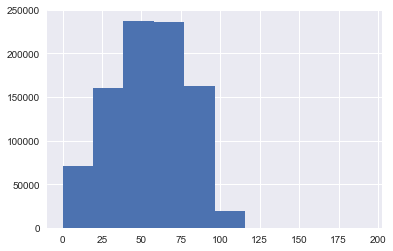

In [0]:
Borrower_Loan_payment.revol_util.hist()

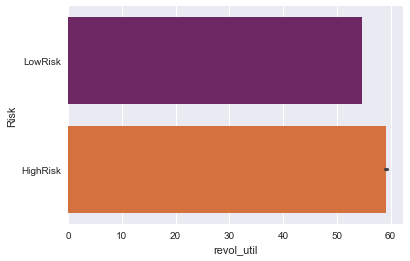

In [0]:
# sns.factorplot(x="revol_util",y="Risk",data=Borrower_Loan_payment,kind="bar", size = 6 )
sns.barplot('revol_util','Risk',data=Borrower_Loan_payment,palette="inferno")

In [0]:
def binning(col, cut_points, labels=None):
    minval = col.min()
    maxval = col.max()


    #create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    #if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    #Binning using cut function of pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin


cut_points = [25,50,75,100]
labels = ["Quarter","Half","ThreeFourth","Full","MoreThanFull"]
Borrower_Loan_payment["revol_util_bin"] = binning(Borrower_Loan_payment["revol_util"], cut_points, labels)
print (pd.value_counts(Borrower_Loan_payment["revol_util_bin"], sort=False))



Quarter         108025
Half            259760
ThreeFourth     315022
Full            201066
MoreThanFull      3504
Name: revol_util_bin, dtype: int64


In [0]:
Borrower_Loan_payment.head()

,index,emp_title,emp_length,home_ownership,zip_code,addr_state,annual_inc,open_acc,pub_rec,total_acc,delinq_2yrs,term,grade,sub_grade,loan_status,pymnt_plan,purpose,application_type,loan_amnt,int_rate,funded_amnt,funded_amnt_inv,installment,dti,inq_last_6mths,mths_since_last_delinq,revol_bal,revol_util,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,earliest_cr_line_month,earliest_cr_line_year,issue_month,issue_year,last_pymnt_month,last_pymnt_year,last_credit_pull_month,last_credit_pull_year,next_pymnt_month,next_pymnt_year,Risk,annual_inc_bin,revol_util_lines,revol_util_bin
0,10,Missing,0,RENT,860xx,AZ,24000.0,3.0,0.0,9.0,0.0,36,B,B2,Fully Paid,n,credit_card,INDIVIDUAL,5000,10.65,5000,4975.0,162.87,27.65,1.0,0.0,13648.0,83.7,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,0.0,0.0,0.0,0.0,0.0,Jan,1985,Dec,2011,Jan,2015,Jan,2016,_,None,LowRisk,L1,4,Full
1,0,Ryder,1,RENT,309xx,GA,30000.0,3.0,0.0,4.0,0.0,60,C,C4,Charged Off,n,car,INDIVIDUAL,2500,15.27,2500,2500.0,59.83,1.00,5.0,0.0,1687.0,9.4,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,0.0,0.0,0.0,0.0,Apr,1999,Dec,2011,Apr,2013,Sep,2013,_,None,HighRisk,L1,0,Quarter
2,10,Missing,2,RENT,606xx,IL,12252.0,2.0,0.0,10.0,0.0,36,C,C5,Fully Paid,n,small_business,INDIVIDUAL,2400,15.96,2400,2400.0,84.33,8.72,2.0,0.0,2956.0,98.5,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,0.0,0.0,0.0,0.0,0.0,Nov,2001,Dec,2011,Jun,2014,Jan,2016,_,None,LowRisk,L1,4,Full
3,10,AIR RESOURCES BOARD,3,RENT,917xx,CA,49200.0,10.0,0.0,37.0,0.0,36,C,C1,Fully Paid,n,other,INDIVIDUAL,10000,13.49,10000,10000.0,339.31,20.00,1.0,35.0,5598.0,21.0,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,0.0,0.0,0.0,0.0,0.0,Feb,1996,Dec,2011,Jan,2015,Jan,2015,_,None,LowRisk,L1,0,Quarter
4,1,University Medical Group,4,RENT,972xx,OR,80000.0,15.0,0.0,38.0,0.0,60,B,B5,Current,n,other,INDIVIDUAL,3000,12.69,3000,3000.0,67.79,17.94,0.0,38.0,27783.0,53.9,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,0.0,0.0,0.0,0.0,0.0,Jan,1996,Dec,2011,Jan,2016,Jan,2016,Feb,2016,LowRisk,L1,2,ThreeFourth


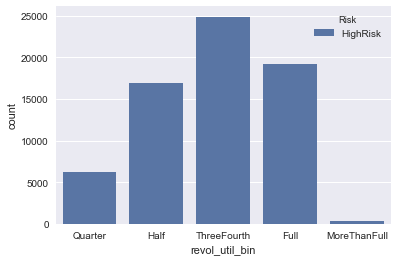

In [0]:
sns.countplot(x='revol_util_bin',hue='Risk',data=Borrower_Loan_payment[Borrower_Loan_payment['Risk']=='HighRisk'])

##### Emp_length

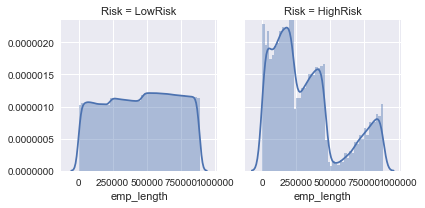

In [0]:
g=sns.FacetGrid(Borrower_Loan_payment, col='Risk')
g = g.map(sns.distplot, "emp_length")

##### Number of Loans

No of Loans issued per year .
Number of issued loans have exponential risen up since 2010.

Text(0,0.5,'Count of Loans issued')

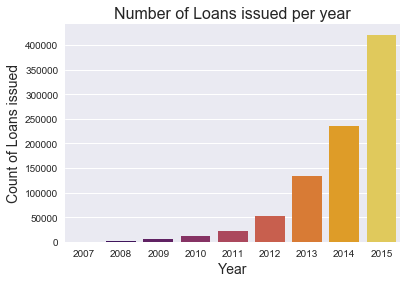

In [0]:
sns.countplot('issue_year',data=Borrower_Loan_payment,palette="inferno")
plt.title('Number of Loans issued per year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Loans issued', fontsize=14)

Low and High Risk Loans per year.
There was increase of High Risk in 2013 and 2014 but it has been seen to come down in 2015.

Text(0,0.5,'Count of Loans issued')

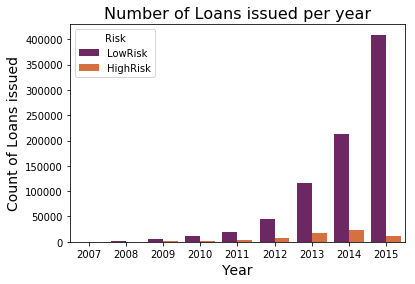

In [0]:
sns.countplot('issue_year',hue='Risk',data=Borrower_Loan_payment,palette="inferno")
plt.title('Number of Loans issued per year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Loans issued', fontsize=14)

##### Employment Duration of Borrower

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


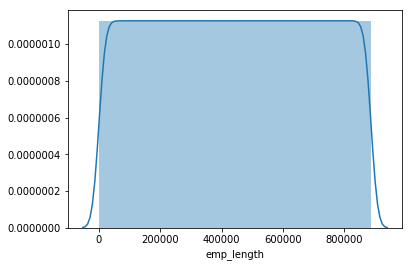

In [0]:
sns.distplot(Borrower_Loan_payment['emp_length'])

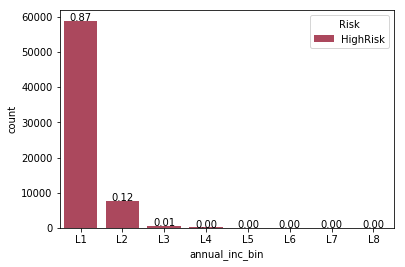

In [0]:
ax=sns.countplot('annual_inc_bin',hue='Risk',data=HighRisk_data,palette="inferno")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/len(HighRisk_data)),
            ha="center") 
plt.show()

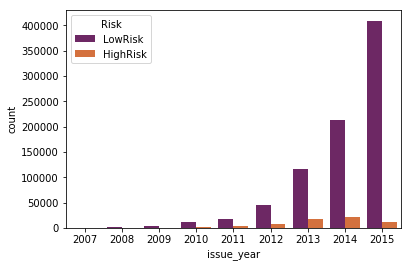

In [0]:
sns.countplot('issue_year',hue='Risk',data=Borrower_Loan_payment,palette="inferno")

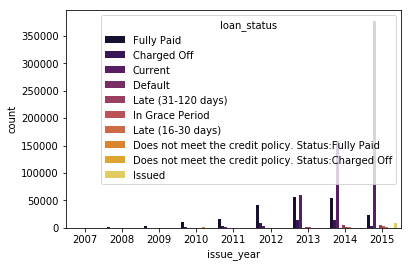

In [0]:
sns.countplot('issue_year',hue='loan_status',data=Borrower_Loan_payment,palette="inferno")

In [0]:
# Borrower_Loan_payment.query('issue_year == 2015' )
Borrower_Loan_payment.issue_month[Borrower_Loan_payment['issue_year']== '2015'].value_counts()
# Borrower_Loan_payment.issue_month[Borrower_Loan_payment['issue_year']== '2007'].value_counts()

Oct    48631
Jul    45962
Dec    44342
Nov    37530
Aug    35886
Apr    35427
Jan    35107
May    31913
Sep    28641
Jun    28485
Mar    25400
Feb    23770
Name: issue_month, dtype: int64

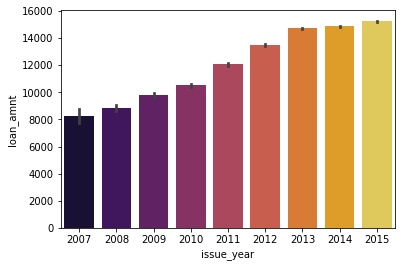

In [0]:
sns.barplot('issue_year','loan_amnt',data=Borrower_Loan_payment,palette="inferno")

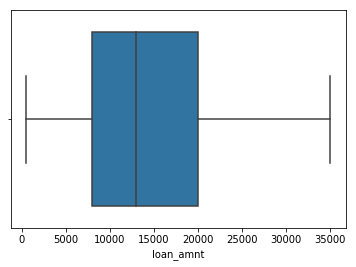

In [0]:
sns.boxplot(Borrower_Loan_payment['loan_amnt'])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


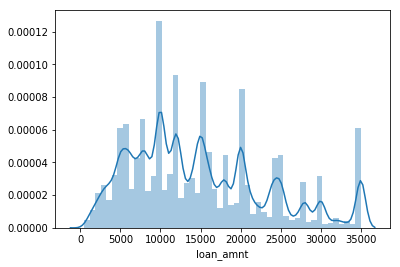

In [0]:
sns.distplot(Borrower_Loan_payment['loan_amnt'])

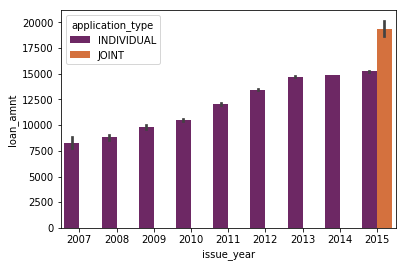

In [0]:
sns.barplot('issue_year','loan_amnt',hue='application_type',data=Borrower_Loan_payment,palette="inferno")

In [0]:
# idx_sorted = HighRisk_data.groupby('purpose').mean().\
#            sort_values('term', ascending=False).index
# ax = sns.catplot(x='term', y='purpose', data=HighRisk_data, ci=None,
#              col='Risk', palette='inferno', order=idx_sorted, kind='bar', height=6)


In [0]:
# fig, ax = plt.subplots(2, 3, figsize=(20, 20))
# sns.distplot(Borrower_Loan_payment['delinq_2yrs'],bins= 5)

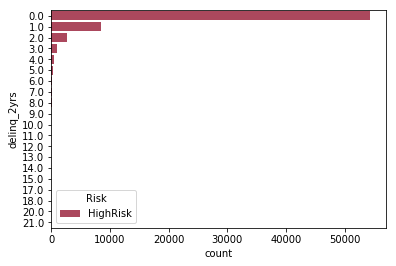

In [0]:
sns.countplot(y="delinq_2yrs", hue="Risk", data=HighRisk_data, palette="inferno")

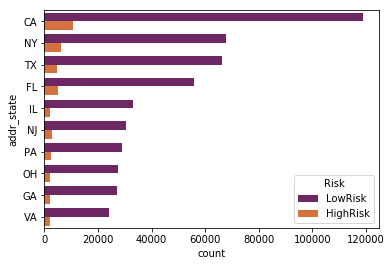

In [0]:
sns.countplot(y="addr_state", hue="Risk", data=Borrower_Loan_payment, palette="inferno",
              order=Borrower_Loan_payment.addr_state.value_counts().iloc[:10].index)

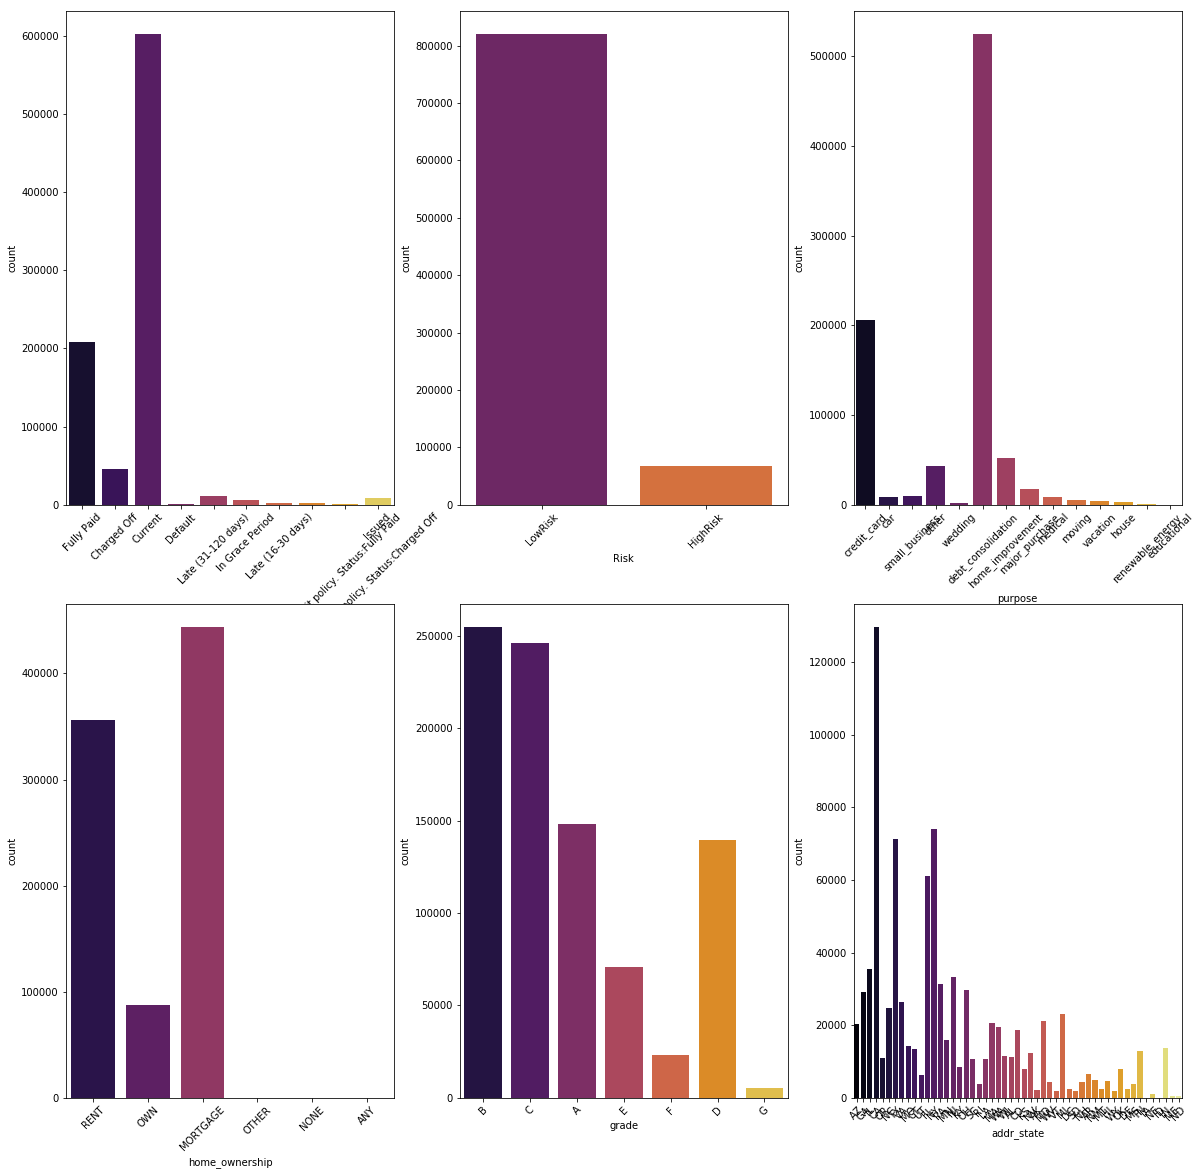

In [0]:
fig, ax = plt.subplots(2, 3, figsize=(20, 20))
categorical=['loan_status','Risk','purpose','home_ownership','grade',  'addr_state']
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(Borrower_Loan_payment[variable], ax=subplot, palette="inferno")
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

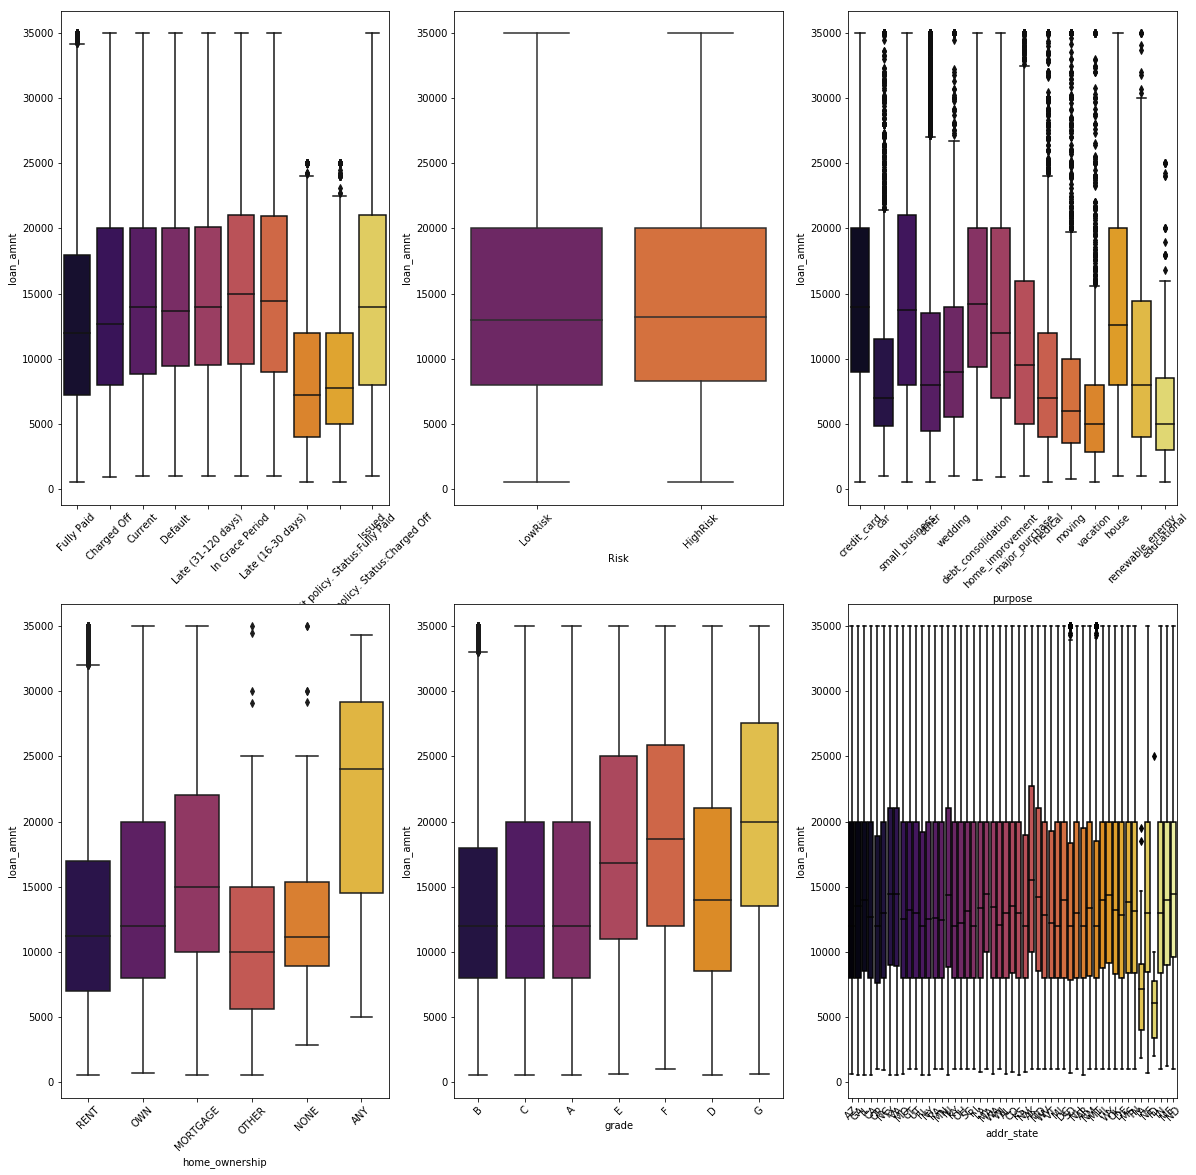

In [0]:
fig, ax=plt.subplots(2,3,figsize=(20,20))
for var, subplot in zip(categorical,ax.flatten()):
    sns.boxplot(x=var,y='loan_amnt',data=Borrower_Loan_payment,ax=subplot, palette="inferno")
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

Text(0.5,1,'Loan AMount by state')

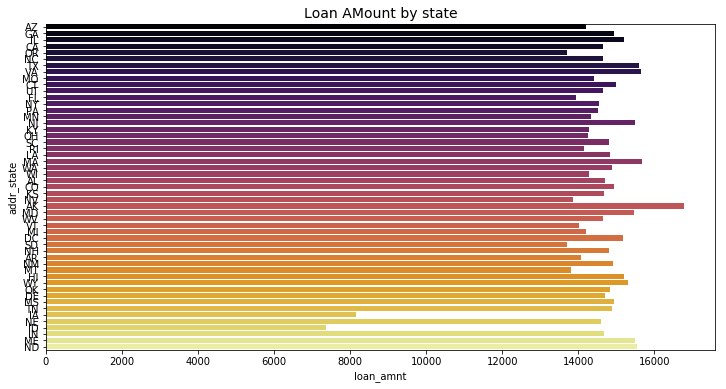

In [0]:
state_sorted = Borrower_Loan_payment.groupby('addr_state').mean()['loan_amnt'].sort_values(ascending=False).index
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='loan_amnt', y='addr_state', data=Borrower_Loan_payment, ci=None,palette="inferno")#, order=idx_sorted )
ax.set_title('Loan AMount by state', size=14)


# state_sorted=Borrower_Loan_payment.groupby(['addr_state'])['loan_amnt'].median().sort_values()
# sns.boxplot(x=Borrower_Loan_payment['addr_state'],y=Borrower_Loan_payment['loan_amnt'],order=list(state_sorted.index))

###### Correlation
Observations:
1. Risk have correlation with Annual Income,Revolving Balance, Funded Amount, Loan Amount

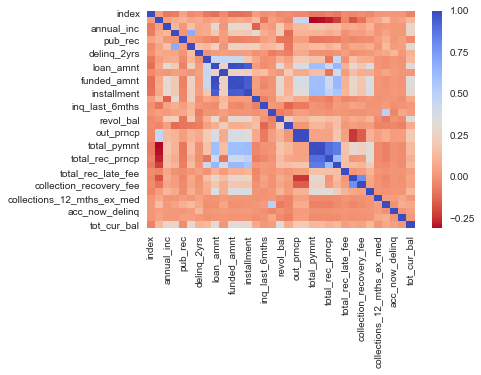

In [0]:
corr=HighRisk_data.corr()
# corr=Borrower_Loan_payment.corr()
sns.heatmap(corr,cmap='coolwarm_r',annot=False, fmt = ".2f")

In [0]:
Borrower_Loan_payment.revol_util = pd.qcut(Borrower_Loan_payment.revol_util.values, 5).codes

Text(0.5,1,'Loan Amount by Purpose')

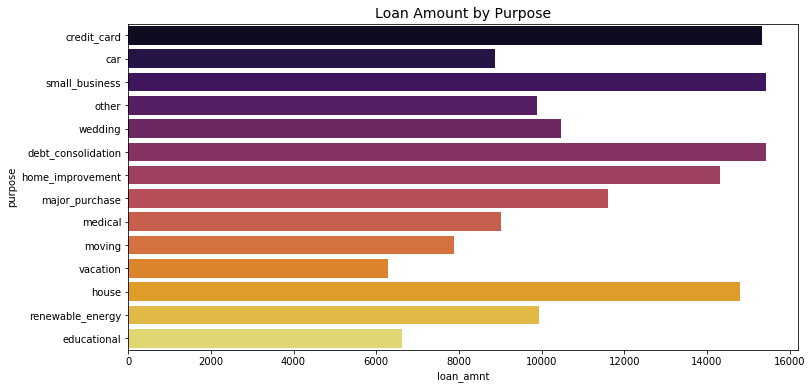

In [0]:
# idx_sorted = Borrower_Loan_payment.groupby('purpose').mean()['funded_amnt'].sort_values(ascending=False).index
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='loan_amnt', y='purpose', data=Borrower_Loan_payment, ci=None,palette="inferno")#, order=idx_sorted )
ax.set_title('Loan Amount by Purpose', size=14)

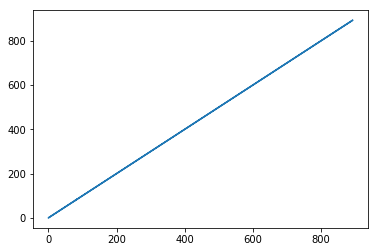

In [0]:
plt.plot(Borrower_Loan_payment['revol_util'],Borrower_Loan_payment['revol_util'])

#### checking if the delinq_2yrs  is having any effect on Target or not 

#### Cross Tabulations 

CrossTabulations are great way to see the frequency and percentage of the features.

Below we can see crosstab of Risk vs Purpose.

In [0]:
pd.crosstab(Borrower_Loan_payment['loan_status'], Borrower_Loan_payment['Risk']).apply(lambda r: round(r/len(Borrower_Loan_payment) *100 ,2), axis=1)

Risk,0,1
loan_status,,
Charged Off,0.00,5.10
Current,67.82,0.00
Default,0.00,0.14
Does not meet the credit policy. Status:Charged Off,0.00,0.09
Does not meet the credit policy. Status:Fully Paid,0.22,0.00
Fully Paid,23.41,0.00
In Grace Period,0.00,0.70
Issued,0.95,0.00
Late (16-30 days),0.00,0.27


In [0]:
pd.crosstab(Borrower_Loan_payment['annual_inc_bin'], Borrower_Loan_payment['Risk']).apply(lambda r: round(r/len(Borrower_Loan_payment) *100 ,4), axis=1)

In [0]:
pd.crosstab(Borrower_Loan_payment['addr_state'], Borrower_Loan_payment['Risk']).apply(lambda r: round(r/len(Borrower_Loan_payment) *100 ,4), axis=1)

In [0]:
pd.crosstab(Borrower_Loan_payment['loan_status'], Borrower_Loan_payment['Risk']).apply(lambda r: round(r/len(Borrower_Loan_payment) *100 ,2), axis=1)

In [0]:
pd.crosstab(Borrower_Loan_payment['purpose'], Borrower_Loan_payment['Risk']).apply(lambda r: round(r/len(Borrower_Loan_payment) *100 ,2), axis=1)

In [0]:
pd.crosstab(Borrower_Loan_payment['home_ownership'], Borrower_Loan_payment['Risk']).apply(lambda r: round(r/len(Borrower_Loan_payment) *100 ,2), axis=1)

In [0]:
pd.crosstab(Borrower_Loan_payment['home_ownership'], Borrower_Loan_payment['purpose'])

In [0]:
pd.crosstab(Borrower_Loan_payment['home_ownership'], Borrower_Loan_payment['delinq_2yrs']).apply(lambda r: r/len(Borrower_Loan_payment), axis=1)


In [0]:
pd.crosstab(HighRisk['home_ownership'], HighRisk['Risk']).apply(lambda r: r/len(HighRisk), axis=1)

In [0]:
pd.crosstab(HighRisk['home_ownership'], HighRisk['delinq_2yrs']).apply(lambda r: r/len(HighRisk), axis=1)


In [0]:
# pd.crosstab(Borrower_Loan_payment['delinq_2yrs'], Borrower_Loan_payment['Risk']).apply(lambda r: r/len(Borrower_Loan_payment), axis=1)
pd.crosstab(Borrower_Loan_payment['Risk'], Borrower_Loan_payment['delinq_2yrs']).apply(lambda r: r/len(Borrower_Loan_payment), axis=1)


## 4. Feature Engineering

##### Dropping Irrelevant Columns

In [0]:
# New=Borrower_Loan_payment.drop(['index','member_id','id'],axis=1)
Borrower_Loan_payment.drop(['earliest_cr_line_month', 'earliest_cr_line_year', 'issue_month',
       'issue_year', 'last_pymnt_month', 'last_pymnt_year',
       'last_credit_pull_month', 'last_credit_pull_year', 'next_pymnt_month',
       'next_pymnt_year','index'],axis=1,inplace=True)

##### Weight of Evidence and IV

Weight of evidence (WOE) and Information value (IV) are simple, yet powerful techniques to perform variable transformation and selection. These concepts have huge connection with the logistic regression modeling technique. It is widely used in credit scoring to measure the separation of good vs bad customers.

Also, IV value can be used to select variables quickly.



<img src="IV.png">

In [0]:
Borrower_Loan_payment.columns

In [0]:
def Calculate_WOE_IV(dataframe, x, y ):
    H=pd.crosstab(dataframe[x],dataframe[y],margins=True) 
    H=H[:-1]
    G=pd.crosstab(dataframe[x], dataframe[y], normalize=True)
    Result=pd.concat([H, G], axis=1)
    Result.columns=['LowRisk Count','HighRisk Count','Total Count','LowRiskPct','HighRiskPct']
    Result['woe']=round(np.log(Result['LowRiskPct']/Result['HighRiskPct']),2)
    Result['IV']=((Result['LowRiskPct']- Result['HighRiskPct']) *Result['woe'])
    Result.sort_values(by=x)
    print(x,'has IV value =',Result['IV'].mean())

for i in range(len(Borrower_Loan_payment.columns)):
    print(Borrower_Loan_payment.columns[i])
    Calculate_WOE_IV(Borrower_Loan_payment, Borrower_Loan_payment.columns[i], 'Risk' )

emp_title


ValueError: Conflicting name "All" in margins

In [0]:
# x='emp_title'
# H=pd.crosstab(Test[x], Test['Risk'], margins=True)                                                                                 
# H=H[:-1]
# G=pd.crosstab(Test[x], Test['Risk'], normalize=True)
# Result=pd.concat([H, G], axis=1)
# Result.columns=['LowRisk Count','HighRisk Count','Total Count','LowRiskPct','HighRiskPct']
# Result['woe']=round(np.log(Result['LowRiskPct']/Result['HighRiskPct']),2)
# Result['IV']=((Result['LowRiskPct']- Result['HighRiskPct']) *Result['woe'])
# Result.sort_values(by=x)
# # Result.index = range(len(Result.index))
# display(Result['IV'].sum())
# display(Result)

##### Again Checking for missing Values



We need to fillna if there is still missing values left in the dataset.
Otherwise Model will not work .

In [0]:
Borrower_Loan_payment=Borrower_Loan_payment[pd.notnull(Borrower_Loan_payment['open_acc'])]

##### Diving data into features and Labels

X will contain all the features from dataset and Y will contain only Label i.e. Risk


In [0]:
Borrower_Loan_payment['Risk']=Borrower_Loan_payment['Risk'].apply(lambda x: 0 if x == 'LowRisk' else 1)

In [0]:
x=Borrower_Loan_payment.drop(['Risk','annual_inc_bin'],axis=1)
y=Borrower_Loan_payment['Risk']

##### One hot encoding

Using Label Encoder is a way of One hot encoding the categorical values.
Since Sklearn libraries do not work properly with string varaibles , we need to convert them.




In [0]:
le = preprocessing.LabelEncoder()
# categorical=['emp_title', 'home_ownership','zip_code','addr_state','grade','sub_grade','loan_status','pymnt_plan',                                'purpose','application_type']
for column_name in x.columns:
    if x[column_name].dtype == object:
        x[column_name] = le.fit_transform(x[column_name])
    else:
        pass


## 5. Train and Test split

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, Y_train, Y_test= train_test_split(x, y, test_size=0.2,random_state=42, stratify=y )

In [0]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)

## 5.Model Training

In [0]:
def validate(data, labels):
    '''
    Ten-fold cross-validation with stratified sampling.
    '''
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    sss = StratifiedShuffleSplit(n_splits=10)
    for train_index, test_index in sss.split(data, labels):
        x_train, x_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    print('Accuracy', np.mean(accuracy_scores))
    print('Precision', np.mean(precision_scores))
    print('Recall', np.mean(recall_scores))
    print('F1-measure', np.mean(f1_scores)) 

In [0]:
# from sklearn import tree
# from sklearn.model_selection import StratifiedShuffleSplit
# clf=tree.DecisionTreeClassifier(class_weight='balanced',min_impurity_split=None,max_depth=6, splitter='best')
# validate(x,y)

In [0]:
from sklearn import tree
clf2=tree.DecisionTreeClassifier(class_weight='balanced',min_impurity_split=None,max_depth=6, splitter='best')
clf2.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
Y_pred = clf2.predict(X_test)
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,163985,0,163985
1,0,13485,13485
All,163985,13485,177470


In [0]:

accuracy_score(Y_test,Y_pred)

1.0

In [0]:
# from sklearn import svm
# clf3 = svm.SVC(C=2,cache_size=7000,tol=1,class_weight={0:.1,1:.9} )
# clf3.fit(X_train,Y_train)

In [0]:
# Y_pred = clf3.predict(X_test)
# pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [0]:
# accuracy_score(Y_test,Y_pred)

In [0]:
from sklearn import  linear_model
clf1= linear_model.LogisticRegression(C=1e5,class_weight= {0:.1, 1:.9} )
clf1.fit(X_train,Y_train)

LogisticRegression(C=100000.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [0]:
%%time
Y_pred = clf1.predict(X_test)
# netMat = (Y_pred == Y_test)
# clf1.coef_
# ind = np.where(Y_test == 1)
# Counter(Y_pred[ind])
# pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Wall time: 62.5 ms


In [0]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,162119,1866,163985
1,3761,9724,13485
All,165880,11590,177470


In [0]:
accuracy_score(Y_test,Y_pred)

0.968293232659041

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,Y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
Y_pred = rfc.predict(X_test)

In [0]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(Y_test,Y_pred))